# Group Convolutional Networks

**Author:** Aron Jansen (work in progress)

This notebook goes through the framework of group convolutional networks, which in addition to being invariant (or equivariant) to translations as vanilla CNNs are, are also invariant (equivariant) to a discrete symmetry group.

This notebook is based on the book, lectures and notebooks on the geommetric deep learning by Micheal Bronstein, Joan Bruna, Taco Cohen and Petar Veličković, found [here](https://geometricdeeplearning.com), and of course also on [the original paper](http://proceedings.mlr.press/v48/cohenc16.html) on group convolutions by Taco Cohen and Max Welling.
All credit goes to them, and all mistakes  are my own.

The notebook is meant to be pedagogical and I hope can be useful as an introduction to group convolutions. I recommend to go through it after or in parallel with the sources above. I go into more detail in some areas and less in other. In particular the implementation of a group convolution layer in Keras is explained in detail.

For pedagogical purposes I think it is already useful in its current state. The implementation itself needs some work. In particular it is still 2-3 times slower than a similar sized network of regular convolutions, it lacks invariant pooling layers, and I want to add more groups.

Any feedback or questions are welcome.

__TODO__:

3. pooling
4. speed ups?
5. other groups

## The group p4m

Before going to group-CNNs, we first explore one particular group as an example: the group of translations, rotations and mirroring of the plane.
This is one of the [wallpaper groups](https://en.wikipedia.org/wiki/Wallpaper_group): a symmetry group containing two translations on a grid, in our case horizontal and vertical translations on a square grid.

What distinguishes a group convolution from a regular one are the symmetries in addition to these translations. These additional symmetries form a group of their own, and is called the point group. 

In the case of our example, the point group is called $D_4$, these are the symmetries of a square: rotations by 90 degrees around the origin, and reflections.

The full wallpaper group with this point group and the two translations on a square grid is called p4m.

Below I will occasionally refer to the point group as the group, because it is only this part of the full group that distinguishes group convolutions from regular convolutions. I hope it is clear from the context.

### Some more context on wallpaper groups (skip on first reading)

There are 17 wallpaper groups in total.  

There are 8 groups on a square or rectangular lattice. Of those 3 have what are called glide reflection symmetries, where one needs to both translate and mirror or rotate at the same time in order for it to be a symmetry. Think of footseps. These have a slighly different structure in that they cannot be decomposed as a point group and the two translations, and we will not consider those either.

Of the 5 remaining ones, the one we will consider, p4m, is the biggest, and contains the others as subgroups. The 5 groups are:


\begin{array}{c|c|c|}
\text{wallpaper group}&\text{point group}&\text{order}&\text{symmetries} & \text{lattice} \\
\hline
\text{p1} & C_1 & 1 &\text{nothing} & \text{oblique} \\
\text{p2} & C_2 & 2 & 180^\circ \text{ rotation} & \text{oblique} \\
\text{pm} & D_1 & 2 & \text{single reflection} & \text{rectangular}\\
\text{pmm} & D_2 & 4 & 180^\circ \text{ rotation, two reflections} & \text{rectangular}\\
\text{cmm} & D_2 & 4 & 180^\circ \text{ rotation, two reflections} & \text{rhombic} \\
\text{p4} & C_4 & 4 &90^\circ \text{ rotations} & \text{square} \\
\text{p4m} & D_4 & 8 & 90^\circ \text{ rotations, two reflections} & \text{square}
\end{array}

Note that the mathematical formalism always assume infinitely extended grids.
An image with a different width and height is still represented on a square grid, as the left-right and up-down neighbors of a pixel are considered to be equally far away. Their different dimensions do however limit the symmetry group to those that are compatible with a rectangular lattice.

On the flip side, a square grid is of course a special case of a rectangular one, so those groups are also compatible with a square grid.


## Derivation of the group structure

A group element takes the form $({\bf t}, r, f)$, which acts on the plane as:
1. $f \in \{0, 1\}$ (True or False) flips along the horizontal direction
2. $r \in \{0, 1, 2, 3\}$ rotates by $r \frac{\pi}{2}$, counterclockwise around the origin
3. ${\bf t} = (t_x, t_y)$ translates

A generic element takes all three actions in the order given.

Consider the pure flips, rotations and translations, and the identity $e$. We write them as follows, and also show their action on the plane:
- $F = (0, 0, 1)$,   
    - $F\cdot(x, y) = (-x, y)$
- $R = (0, 1, 0)$
    - $R\cdot(x, y) = (-y, x)$
- ${\bf t} = ({\bf t}, 0, 0)$
    - ${\bf t}\cdot(x, y) = (x + t_x, y + t_y)$
- $e = (0, 0, 0)$
    -  $e \cdot (x, y) = (x, y)$

(Where for later clarity we write the action of a group element $g$ on a point $(x, y)$ as $g \cdot (x, y)$.)

Then we can write any element as:
$({\bf t}, r, f) = {\bf t} \odot R^r \odot F^f$, where $\odot$ denotes group composition.

Each component creates its own subgroup:
- $F \odot F = e$, flips are a 2 dimensional subgroup
- $R^r \odot R^s = R^{r + s \mod 4}$, rotations give the 4-dimensional cyclic group
- ${\bf t} \odot {\bf r} = \bf{t + r}$, translations trivially form the group of translations

Now to find the group composition, we need to untangle the following expression,
$a \odot b = {\bf t}_a \odot R^{r_a} \odot F^{f_a} \odot {\bf t}_b \odot R^{r_b} \odot F^{f_b} = {\bf t}_c \odot R^{r_c} \odot F^{f_c} = c$.

So we want to pull first the $F^{f_a}$ past the ${\bf t}_b \odot R^{r_b}$ to find $f_c$, and then pull $R^{r_b}$ past ${\bf t}_b$ to find $r_c$, which will then also allow us to find ${\bf t}_c$.
These do not commute, but by looking at the action on the plane we can see how we can still swap elements:

- $\begin{align}
(F \odot {\bf t})\cdot(x, y) &= F\cdot(x + t_x, y + t_y) = (-x - t_x, y + t_y)\\
&= (F\cdot{\bf t})\cdot(-x, y) = ((F\cdot{\bf t}) \odot F)\cdot(x, y)
\end{align}$
- $\begin{align}
(F \odot R)\cdot(x, y) &= F\cdot(-y, x) = (y, x) \\
&= R^{-1}\cdot(-x, y) = (R^{-1}\odot F)\cdot(x, y)
\end{align}$
- $\begin{align}
(R \odot {\bf t})\cdot(x, y) &= R\cdot(x + t_x, y + t_y) = (- y - t_y, x + t_x)\\ &= (R\cdot{\bf t})\cdot (-y, x) = ((R\cdot {\bf t}) \odot R)\cdot(x, y)
\end{align}$

where in the second and last lines we let $F$ and $R$ act on ${\bf t}$ as a point in the plane.

Since these three identities hold for all points $(x, y)$, they imply:
- $F \odot {\bf t} = (F{\bf t}) \odot F$
- $F \odot R = R^{-1} \odot F$
- $R \odot {\bf t} = (R{\bf t}) \odot R$

With these identities, we can write the product of two generic group elements, $a \odot b$, and bring all the flips to the far right, the rotations to the middle and the translations to the left. Doing this and reading off the resulting components gives the following rules for group composition:
- $f_c = f_a + f_b$
- $r_c = r_a + (1 - 2 f_a) r_b$
- ${\bf t}_c = {\bf t}_a + R^{r_a} F^{f_a} {\bf t}_b$

And from this we can find the inverse element:
- $f^{-1} = f$
- $r^{-1} = - (1 - 2 f) r$
- ${\bf t}^{-1} = - F^f R^{-r} {\bf t}$

The class below implements this group. It uses multiplication as group composition, and `~` can be used as the inverse.

In [1]:
class P4M:
  """
  First flip horizontally, then rotate counterclockwise around origin, then translate.
  """
  def __init__(self, rotation: int=0, flip: int=0, translation: tuple=(0, 0)):
    assert type(translation) == tuple
    self.rotation = rotation % 4
    self.flip = flip % 2
    self.translation = translation
  
  def __mul__(a, b):
    """Group composition a o b."""
    flip = (a.flip + b.flip) % 2
    rotation = (a.rotation + (1 - 2 * a.flip) * b.rotation) % 4
    a_x, a_y = a.translation
    b_x, b_y = b.translation
    if a.flip:
      b_x = -b_x
    for _ in range(a.rotation):
      b_x, b_y = P4M.rotate(b_x, b_y)
    translation = (a_x + b_x, a_y + b_y)

    return P4M(rotation=rotation, flip=flip, translation=translation)

  def __invert__(self):
    """Group inverse."""
    flip_inv = self.flip
    rotation_inv = (-(1 - 2 * self.flip) * self.rotation) % 4
    x_inv, y_inv = self.translation
    for _ in range(self.rotation):
      x_inv, y_inv = P4M.inv_rotate(x_inv, y_inv)
    if self.flip:
      x_inv = -x_inv

    translation_inv = x_inv, y_inv
    return P4M(rotation=rotation_inv, flip=flip_inv, translation=translation_inv)

  def __call__(self, point):
    """Action on plane."""
    result_x, result_y = point
    if self.flip:
      result_x = -result_x
    for _ in range(self.rotation):
      result_x, result_y = P4M.rotate(result_x, result_y)
    t_x, t_y = self.translation
    return result_x + t_x, result_y + t_y

  def __repr__(self):
    return f'({self.translation}, {self.rotation}, {self.flip})'

  def __str__(self):
    if self.is_identity():
      return 'e'
    string = ''
    if self.translation != (0, 0):
      string += f'{self.translation}'
    if self.rotation > 0:
      string += f'R^{self.rotation}'
    if self.flip:
      string += 'F'

    return string

  def is_identity(self):
    return self.flip == 0 and self.rotation == 0 and self.translation == (0, 0)

  def __eq__(self, other):
    return self.flip == other.flip and self.rotation == other.rotation and self.translation == other.translation
  
  @staticmethod
  def rotate(x, y):
    return -y, x

  @staticmethod
  def inv_rotate(x, y):
    return y, -x

  def __hash__(self):
    return hash((self.flip, self.rotation, self.translation))

## Check the identities

Now we can check the identities we used to derive the group composition. We define `F` and `R` as above to be the flip and single rotation.

The translation is a bit more involved for two reasons. First, we didn't have a single representative of this subgroup. It can of course be built from two generators (the unit translation in the x direction and the unit translation in the y direction), but this only complicates things, so we just pick a generic point.

The more interesting complication is that we can identify a pure translation in the group with a point on the plane, on which the group acts. It makes the code a bit more cumbersome than for the identity that doesn't involve a translation, but that is good in that it stresses that these are two different objects. In most cases such a mapping cannot be done.

In [2]:
F = P4M(flip=1)
R = P4M(rotation=1)
T_point = (4, 2)
T = P4M(translation=T_point)

print(F * T == P4M(translation=F(T_point)) * F)
print(F * R == ~R * F)
print(R * T == P4M(translation=R(T_point)) * R)

True
True
True


## Checking the full multiplication table

We can also easily construct the multiplication table of the group, or really the table of group compositions, for the point group.

First we make a list of the elements in the group:

In [3]:
unique_elements = []
for flip in range(2):
  for rotation in range(4):
    unique_elements.append(P4M(flip=flip, rotation=rotation))
  
print(' '.join([str(g) for g in unique_elements]))

e R^1 R^2 R^3 F R^1F R^2F R^3F


And then we can just multiply them to find the group compositions:

In [4]:
products = [[a * b for b in unique_elements] for a in unique_elements]

Which we can display nicely as below. The rows and columns are group elements $g_r$ and $g_c$, and the entries in the table denote the result of composing them as $g_{rc} = g_r \odot g_c$.

This can be compared for instance to [this table](https://proofwiki.org/wiki/Dihedral_Group_D4/Cayley_Table). Note that apart from remaning $R$ to $a$ and $F$ to $b$, these tables are not the same. The reason is that we have chosen a different basis: we first apply flips and then rotations, while in the linked table flips are applied after rotations. It is left as an exercise to the reader to show that the two tables are in fact consistent.

In [5]:
from tabulate import tabulate

print("Group composition: row o column")
print(tabulate(products, headers=unique_elements, showindex=unique_elements, tablefmt='fancy_grid'))

Group composition: row o column
╒══════╤══════╤═══════╤═══════╤═══════╤══════╤════════╤════════╤════════╕
│      │ e    │ R^1   │ R^2   │ R^3   │ F    │ R^1F   │ R^2F   │ R^3F   │
╞══════╪══════╪═══════╪═══════╪═══════╪══════╪════════╪════════╪════════╡
│ e    │ e    │ R^1   │ R^2   │ R^3   │ F    │ R^1F   │ R^2F   │ R^3F   │
├──────┼──────┼───────┼───────┼───────┼──────┼────────┼────────┼────────┤
│ R^1  │ R^1  │ R^2   │ R^3   │ e     │ R^1F │ R^2F   │ R^3F   │ F      │
├──────┼──────┼───────┼───────┼───────┼──────┼────────┼────────┼────────┤
│ R^2  │ R^2  │ R^3   │ e     │ R^1   │ R^2F │ R^3F   │ F      │ R^1F   │
├──────┼──────┼───────┼───────┼───────┼──────┼────────┼────────┼────────┤
│ R^3  │ R^3  │ e     │ R^1   │ R^2   │ R^3F │ F      │ R^1F   │ R^2F   │
├──────┼──────┼───────┼───────┼───────┼──────┼────────┼────────┼────────┤
│ F    │ F    │ R^3F  │ R^2F  │ R^1F  │ e    │ R^3    │ R^2    │ R^1    │
├──────┼──────┼───────┼───────┼───────┼──────┼────────┼────────┼────────┤
│ R^1F

### Group composition as permutations

By enumerating the group elements in the order above, we can represent the group composition as a set of permutations. 

The $r$-th group element $g_r$ defines a permutation of the whole group, where
$g_r \odot g_c = g_k$, with $k = permutations[r][c]$.

In [6]:
elem_numbers = {g: i for i, g in enumerate(unique_elements)}
permutations = [[elem_numbers[g] for g in row] for row in products]
permutations

[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 0, 5, 6, 7, 4],
 [2, 3, 0, 1, 6, 7, 4, 5],
 [3, 0, 1, 2, 7, 4, 5, 6],
 [4, 7, 6, 5, 0, 3, 2, 1],
 [5, 4, 7, 6, 1, 0, 3, 2],
 [6, 5, 4, 7, 2, 1, 0, 3],
 [7, 6, 5, 4, 3, 2, 1, 0]]

### Checking inverses

In [7]:
print(' '.join([str(g * ~g) for g in unique_elements]))
print(' '.join([str(~g * g) for g in unique_elements]))

e e e e e e e e
e e e e e e e e


## Group action

Even though we introduced the group by starting from the symmetries of the plane, mathematically a group is independent of its actions on any other objects. It is defined purely by the group composition.

In particular the same group can act on many different spaces, and even on a fixed space and for a fixed group, different actions can be defined.

The defining property of a group action is that if we do multiple transformations, it doesn't matter how we do it.
We either compose the two group elements, and let the resulting group element act on the space. Alternatively and equivalently, we can first act with one group element, and then with the other:

$(g \odot h) \cdot x = g \cdot (h \cdot x)$

In fact this property is what we implicitly used above to go from the action on the plane that we wanted to the underlying group structure. 

#### Action on grid $\Omega$

Before verifying whether this property holds, we need to define the action on a grid. Luckily the rotations and mirrorings map to simple tensorflow operations.
With the three elementary transformations:

- horizontal flip
- vertical flip
- transposition

we can create 2^3 = 8 different transformations, which map exactly to the previously discussed action on the plane.

In [8]:
import tensorflow as tf

def flip_grid(x, height_axis=-3, width_axis=-2):
  return tf.reverse(x, axis=[width_axis])

def rotate_grid(x, height_axis=-3, width_axis=-2):
  axes = list(range(len(x.shape)))
  axes[height_axis], axes[width_axis] = axes[width_axis], axes[height_axis]
  return tf.reverse(tf.transpose(x, perm=axes), axis=[height_axis])

def act_on_grid(x, g, height_axis=-3, width_axis=-2):
  if g.flip:
    x = flip_grid(x, height_axis=height_axis, width_axis=width_axis)
  for _ in range(g.rotation):
    x = rotate_grid(x, height_axis=height_axis, width_axis=width_axis)
  return x

To demonstrate what this action does to the grid, we need some more structure, as by construction the actions all leave the grid itself invariant.

We can take an image on the grid, which is nothing but an assignment of pixel values to each point in the grid. At this point we use this merely to illustrate that the action above does what we want it to. Later we will see that the desired action of the group on _signals on the grid_ is subtly different from the action on the grid itself. 

It is also for later convenience that we have set the default height and width axes to be -3 and -2, as the last index will be reserved for values on the grid.

Also note that for rotation to be a symmetry the grid clearly needs to be square. For generality though we will keep distinguishing the height from the width. (Restricting the group to horizontal and vertical flips will still give a nontrivial symmetry if the grid is not square.)

#### Illustrate action on MNIST

In [9]:
from tensorflow import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)

input_shape = (28, 28, 1)
num_classes = 10

from matplotlib import pyplot as plt
import numpy as np

image = np.reshape(x_train[2].numpy(), (28, 28, 1))

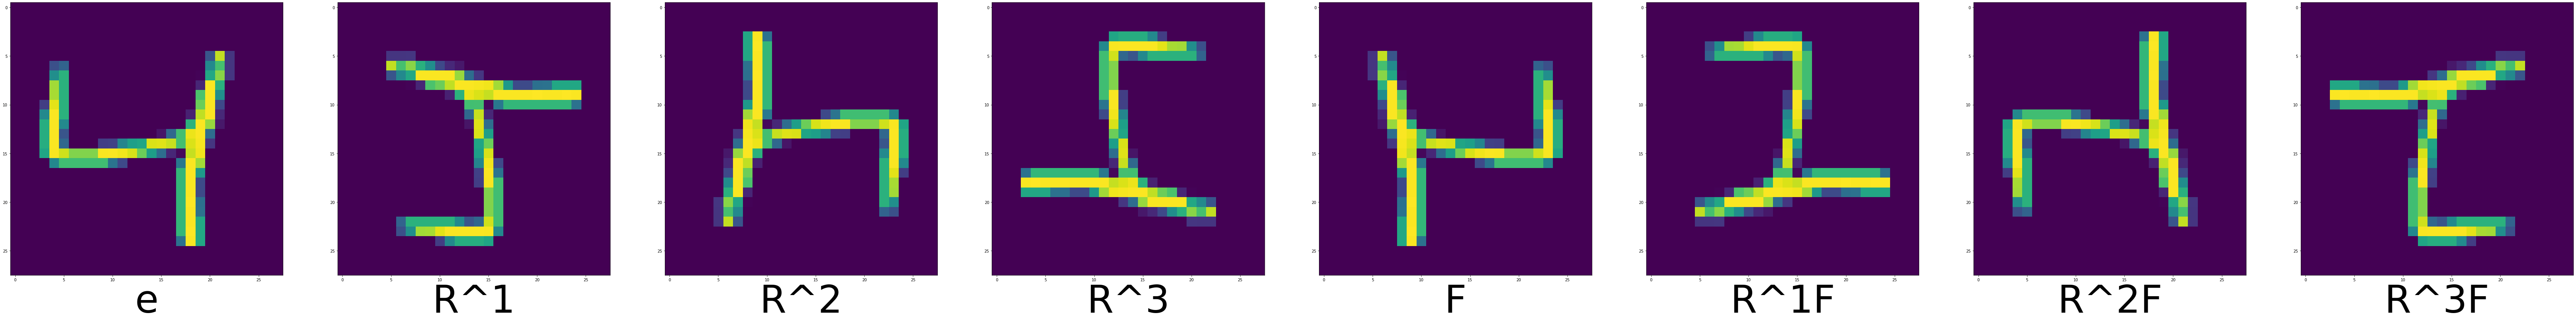

In [10]:
transformed_images = [act_on_grid(image, g) for g in unique_elements]

fig, axes = plt.subplots(1, 8)
fig.set_figheight(2 * 15)
fig.set_figwidth(8 * 15)
for i in range(8):
  axes[i].imshow(transformed_images[i][:, :, 0])
  axes[i].set_xlabel(str(unique_elements[i]), fontsize=100)
fig.show()

#### Checking compatibility of composition and action

Now that we have defined the action on the grid, we can check if this is compatible with group composition. We might as well test it on the digit above.

We compute the quantity $(g_r \odot g_c)(x) - g_r \cdot (g_c \cdot x)$ and indeed find that it vanishes for all combinations of group elements.

In [11]:
differences = [[0 for _ in unique_elements] for _ in unique_elements]
for r in range(8):
  for c in range(8):
    g_r = unique_elements[r]
    g_c = unique_elements[c]
    g_rc = unique_elements[permutations[r][c]]

    gc_x = act_on_grid(image, g_c)
    gr_gc_x = act_on_grid(gc_x, g_r)
    grc_x = act_on_grid(image, g_rc)

    differences[r][c] = tf.reduce_max(tf.abs(grc_x - gr_gc_x)).numpy()

for row in differences:
  print(row)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## Group action on signals

So far we have interpreted the group as acting on the grid. We have also in a way looked at the action of the group on itself: this is just another way of looking at the group composition rules we derived.

A crucial property of both of these actions is that it doesn't matter where we put the brackets. In fact this must be true of any action for it to make sense.

### Signals

Ultimately though we are not interested in just the grid or even the group by itself. We want to classify images or other machine learning tasks.
So rather than a grid by itself, we want to analyse data on a grid, in particular pixel values on each grid point.

A formal way of looking at an image is as a signal on the grid: a function from the grid to the real numbers, or to 3 real numbers for color images. We denote the set of all such functions as $\mathcal{X}(\Omega, \mathcal{C}) \equiv \{f: \Omega \rightarrow \mathcal{C} \}$, where $\Omega$ is the grid itself, and $\mathcal{C}$ will typically be $\mathbb{R}^n$ for some number of features $n$.

The data itself of a color image will still be a tensor of shape (height, width, 3), whose entry i,j gives the RGB values at the i,j-th gridpoint.
We are free to think of the first two axes to be inputs to a function, and the last axis to be the corresponding output. The data defines a function by giving its value on all of the possible inputs, i.e. all grid points.





#### Group Actions

From a group G acting on a domain $\Omega$, we can immediately construct an action of the group on signals $\mathcal{X}(\Omega, \mathcal{C})$ on this domain: for $g \in G$, $y \in \mathcal{X}(\Omega, \mathcal{C})$ and $x \in \Omega$:

$(g \otimes y)(x) = y(g^{-1} \cdot x)$.

The inverse here is crucial to make this a proper group action. This can be seen by looking at another group element $h \in G$ and verifying that this makes the action compatible with group composition:

$(h \otimes (g \otimes y))(x)  = (g \otimes y)(h^{-1} \cdot x) = y(g^{-1} \cdot (h^{-1} \cdot x)) = y((g^{-1} \odot h^{-1}) \cdot x) = y((h \odot g)^{-1} \cdot x) = ((h \odot g) \otimes y)(x)$

where we used that $(h \odot g)^{-1} = g^{-1} \odot h^{-1}$.

So the action on the image we did before wasn't a proper action, as we didn't use the inverse.

We have just created a representation of the group on signals on the domain $\Omega$ purely through the group action directly on $\Omega$ that we already had. But we also already had another group action: the one on the group itself by composition. Using this we can repeat the trick to create a group action on signals on the group itself.

To summarize, these are the relevant group actions.

\begin{array}{c|cccc}
\text{space}&\text{action}&\text{computed as} & \text{meaning} & \text{shape}\\
\hline
\Omega& g \cdot p & - & \text{pixel indices} & (h, w)\\
G & g \odot h & - & \text{transformations} & (h, w, n_g)\\
\mathcal{X}(\Omega) & (g \otimes x)(p) & x(g^{-1}\cdot p) & \text{image} & ( h, w, n_c)\\
\mathcal{X}(G) & (g \circ y)(h) & y(g^{-1} \odot h) & \text{hidden activations} & (h, w, n_g, n_c)
\end{array}

In the two signal spaces, note that the group action does not depend on the image of the signals, only their domain. That is why the image is not indicated, although in both cases it will turn out to be the group itself for group convolutions.

We have reduced the 4 actions effectively to two: the action on the domain and the composition of group elements.
As the group in question is a combination of translations and a point group, we can decompose this further. In fact, the group composition acts on the translational part exactly as it does on the domain itself. We can easily check this with an example:

In [12]:
g = T * F * R
print('g: ', g)

h = P4M(translation=(3, 1)) * F
print('h: ', h)
x = (3, 1)
print('x: ', x)
print('gx: ', g(x))
print('gh: ', g * h)

g:  (4, 2)R^3F
h:  (3, 1)F
x:  (3, 1)
gx:  (5, 5)
gh:  (5, 5)R^3


So the action on the group can be decomposed as first acting on the translation group element as if it was in the domain itself, and then acting on the point group elements. This last part by definition is nothing but a permutation, and for a given group element the corresponding permutation is precisely the one indicated in the multiplication table above.

So to act with a particular group element $g$ on a signal $\mathcal{X}(G)$ of shape $(n_h, n_g, h, w)$:

1. Apply the flip and rotation on the $(h, w)$ dimensions
2. Apply the translation on the $(h, w)$ dimensions
3. Permute the $n_g$ dimension according to the row of $g$ in the multiplication table.

And acting on signals on the domain $\mathcal{X}(\Omega)$ is the same, simply omit the last step.

Generalizing this to any group that combines translations with a point group, the two pieces of information we need for every point group element are these:
1. an action on $\mathcal{X}(\Omega, \mathcal{C})$


In [13]:
@tf.function
def P4M_action(kernel, new_group_axis=0, height_axis=0, width_axis=1):
  return tf.concat([tf.expand_dims(act_on_grid(kernel, g, height_axis=height_axis, width_axis=width_axis), 
                                   axis=new_group_axis) for g in unique_elements], axis=new_group_axis)

2. A permutation giving the point-group part of the group composition

Here we have to be careful. The action above in an action on signals on the domain. So the result of applying this action on an image $x \in \mathcal{X}(\Omega, \mathcal{C})$ is a tensor of the form

$(g, g \otimes x(u)) = (g, x(g^{-1} \cdot u))$

because that is how the group acts on a signal on the domain.

Now we also want to implement the action on a signal on the group $y \in \mathcal{X}(G, \mathcal{C})$. If we split the group element into a translational part $u$ (equivalently a point in the grid), and a non-translational part $h$, then another group element $g$ should act on this signal to produce a tensor of the form:

$(g, g \odot y(h, u)) = (g, y(g^{-1} \otimes h, g^{-1} \cdot u))$

The action on $u$ is already taken care of, we can just apply the action above first. But for the action on the non-translational part of the group, we need to act on it with the inverse group element $g^{-1}$.

So we actually need a different permutation matrix, because we had `permutations`[r][c]$ = g_r \otimes g_c$, but what we need to use is `permutations_inv`[r][c]$ = g_r^{-1} \otimes g_c$. Fortunately we can create this jsut as easily:

In [14]:
products_inv = [[(~a) * b for b in unique_elements] for a in unique_elements]
permutations_inv = [[elem_numbers[g] for g in row] for row in products_inv]
P4M_permutation = tf.constant(permutations_inv)

Finally the translations are of course already implemented in vanilla CNNs. We will modify Keras's Conv2D layer to add the two pieces of information above.

# Geometric DL Blueprint

The philosophy of geometric deep learning is to maximally use the symmetries of the domain by stacking layers that are equivariant, potentially ending in an invariant layer if the network's output should be invariant (as is the case in image classification, but not for instance in image segmentation).

In general a function $f: X \rightarrow Y$ is equivariant to some symmetry group $G$ of its domain $X$ if for all inputs $x \in X$ and all group elements $g \in G$:

__equivariance:__

$f(g \cdot x) = (g \otimes f)(x)$

and invariance is the special case where the action on the function is trivial:

__invariance:__

$f(g \cdot x) = f(x)$

These properties are what we would like layers of the neural network to have. Such layers send for instance an image to a smaller "image" of features. So a layer is a map from signals on the domain to other signals on a domain (the same or another). This is the third layer of abstraction, it is useful to list these to avoid confusion:
1. The domain $\Omega$: a grid of points without values
2. Signals $\mathcal{X}(\Omega, \mathcal{C})$: images on the grid
3. maps between signals $\{\mathcal{X}(\Omega, \mathcal{C}) \rightarrow \mathcal{X}(\Omega^\prime, \mathbb{R})\}$: neural network layers

The most interesting equivariant layer is the group-convolution layer, which we discuss next.

## Equivariant Layer: Group convolution

### Normal convolution

Before diving into group convolution it's useful to rephrase regular convolution in this language. There too a convolution layer is a map between signals, say from pixel values on a grid, to hidden feature vectors on the same grid (or possibly a smaller grid if we don't use padding or use a stride). Both grids have translation invariance.

For an image, or signal on the grid $x \in \mathcal{X}(\Omega, \mathcal{C})$, and a kernel, which is also a signal on the grid, $\psi \in \mathcal{X}(\Omega, \mathcal{C})$, we denote the convolution by the map $F_\psi: \mathcal{X}(\Omega, \mathcal{C}) \rightarrow \mathcal{X}(\Omega^\prime, \mathcal{C}^\prime)$, defined as

$F_\psi(x)(t) \equiv (\psi \star x)(t) = \sum_{u \in \Omega} \langle \psi(u - t), x(u) \rangle_\mathcal{C}$

here $\langle \cdot, \cdot \rangle_\mathcal{C}$ is just the inner product: $x(u)$ is a feature vector with m components, then a single kernel is too, and convolution sums their inner products to produce a single number at each grid point. In practice of course we use multiple kernels, to go from an $m$-dimensional feature vector to a, possibly larger, $m^\prime$-dimensional feature vector.

The argument of the filter is translated by $-t$. We can rephrase this by thinking of $t$ as an element of the translation group, rather than a point on the grid. We had already seen that for this particular case the group and the domain happen to coincide. So $u - t = t^{-1} \cdot u$, where on the left hand side $t$ is a point on the grid and on the right hand side it is an element of the translation group. Using the action on signals, we can take it outside of the argument: $\psi(t^{-1} \cdot u) = (t \otimes \psi)(u)$. So we can write the convolution as:

$(\psi \star x)(t) = \sum_{u \in \Omega} \langle(t \otimes \psi)(u), x(u)\rangle_\mathcal{C}$

where importantly we now interpret the argument $t$ of the convolved signal as a group element.

Note that locality, another feature of convolutions as they are usually done, which is essential to its success, is not apparent here. In fact it is not strictly necessary, but can be easily imposed just by setting the kernel to zero everywhere but on a small square. 

What is apparent is the other feature crucial to the success of convolutions: weight sharing. The output at any element of the translation group is computed using the same kernel. This is what makes it equivariant to translations, but rather than show that now we first generlaize this to group convolutions, and then show it for the more general case.

### Lifting convolution

Having framed the normal convolution in this way, the generalization to group convolutions is almost immediate. A  _group convolution_ is a map:
$F_\psi^G: \mathcal{X}(\Omega, \mathcal{C}) \rightarrow \mathcal{X}(G, \mathbb{R})$ defined as:

$F_\psi^G(x)(g) \equiv (\psi \star x)(g) = \sum_{p\in\Omega} \langle(g \otimes \psi)(p), x(p)\rangle_\mathcal{C}$.

In particular this is also called a _lifting convolution_, because it maps signals on the domain to signals on the group.

This reduces to the normal convolution when the group $G$ is only the translation group, but here we will think of it as including more symmetries.

To see that this is $G-$equivariant, transform either the output or the input with $h \in G$ using the previously defined group actions:
- $(h \circ F_\psi^G(x))(g) = F_\psi^G(x)(h^{-1} \odot g) = \sum_{p\in\Omega} \langle [(h^{-1} \odot g) \otimes \psi](p), x(p) \rangle_\mathcal{C}$
- $F_\psi^G(h \otimes x)(g) = \sum_{p\in\Omega} \langle (g \otimes \psi)(p), (h \otimes x)(p)\rangle_\mathcal{C}$

So if we can show that

$\sum_{p\in\Omega}\langle [(h^{-1} \odot g) \otimes \psi](p), x(p) \rangle_\mathcal{C} = \sum_{p\in\Omega} \langle (g \otimes \psi)(p), (h \otimes x)(p)\rangle_\mathcal{C}$

then $F_\psi^G$ is $G-$equivariant. 
We can make the left hand side look more like the right hand side by rewriting it as:
- $[(h^{-1} \odot g) \otimes \psi](p) = [h^{-1} \otimes (g \otimes \psi)](p) = (g \otimes \psi)(h \cdot p)$, and
- $x(p) = (h \otimes x)(h \cdot p)$

so that we get

$\sum_{p\in\Omega}\langle (g \otimes \psi)(h \cdot p), (h \otimes x)(h \cdot p) \rangle_\mathcal{C} = \sum_{p\in\Omega} \langle (g \otimes \psi)(p), (h \otimes x)(p)\rangle_\mathcal{C}$

where now the only difference is that on the left we have $h \cdot p$ as arguments and on the right we have only $p$.
So without the sum, the two sides are _not_ equal, but as long as both sides still sum over the same set, they are equal. So what we need is that $h \cdot \Omega = \Omega$, for any $h \in G$. 

This is true because any action of a group $G$ on a domain $\Omega$ defines a bijection from $\Omega$ to itself, i.e. the sets are indeed the same.
This can be seen from the existance of the inverse $h^{-1} \in G$: if $h\cdot p = h\cdot q$, then by applying $h^{-1}$ to both sides we get $p = q$.

### Group convolution

We've considered convolution of signals on $\Omega$, but they get mapped to signals on the group. So if we want to have more than a single convolution layer, we'll need to define convolution of signals on the group as well.

Fortunately, the definition is almost identical, and signals on the group remain signals on the group. For completeness, a group convolution is a map $F_\psi^G: \mathcal{X}(G,\mathcal{C})\rightarrow \mathcal{X}(G, \mathbb{R})$ defined as

$F_\psi^G(y)(g) \equiv (\psi \star y)(g) = \sum_{h\in G} \langle(g \circ \psi)(h), y(h)\rangle_\mathcal{C}$,

where now $y, \psi \in \mathcal{X}(G, \mathcal{C})$.


The proof of equivariance goes through in the same way, as also $h\odot G = G$, since for all $g$, $h^{-1} \odot g \in G$ and so $g \in h \odot G$.

Note that nowhere in this discussion we have used that the group contains translations, this is not necessary in order to define a group convolution.

### Practical implementation

As already noted, an efficient implementation of regular convolutions is already available in many frameworks, most importantly for us in Keras's `Conv2D` layer. We will subclass this layer to make an efficient implementation of group convolutions.

We'll make sure the layer has input and output shapes that are natural, meaning that signals on the group will have an additional axis. This won't work with the `Conv2D` layer though, so internally we'll need to merge this axis with the channel axis.

So at a high level the name of the game is to first reshape the kernels so we can apply the group transformation, reshape them and the input again so we can apply the convolution, and then reshape the result to get it into a natural form.

Rather than showing the whole class here, we'll discuss the main methods here and then import it.

_From here on, when I say group I mean only the point group, here the rotations and reflections, as the translational part is already taken care of._

#### Initialization

As mentioned, the only dependence on the group is through its composition, represented by a tensor of permutations, and its action. To decouple the details of the group from the implementation of the group convolution, and make it able to generalize to any group, we'll pass these as arguments. So the init method will look like this:

In [15]:
def __init__(self, group_action, group_composition: tf.Tensor, **kwargs):
  self.group_action = group_action
  self.group_composition = group_composition
  self.group_order = group_composition.shape[0]
  self.group_valued_input = None # set during build

  super().__init__(**kwargs)

Where we extract the group order, i.e. the number of elements, from the group composition. Note that group order here refers only to the non-translational part of the group, as that part is already handled by the standard convolution.

We also include a boolean `group_valued_input` indicating whether the layer acts on signals on the group. 


#### build

The build method does two things. One is to find out whether the layer is being applied to group valued input and set the flag. 

If the input is a signal on the domain rather than the group, it is already of the shape expected by the `Conv2D` layer and we're done. 

If the input _is_ a signal on the group, it will have, by our conventions, a shape `(batch, height, width, group_order, channels_in)`, whereas `Conv2D` expects a shape `(batch, height, width, channels_in)`, so we need to get rid of the extra group axis somehow.

What we can do is to merge it with the `channels_in` axis, so instead of having a vector of size `channels_in` for each group element, we'll have a vector of size `in_channels * group_order` on each point in the grid (i.e. each translational group element). 

Then we call `Conv2D`'s build method with this input shape. This will create the kernel, which will be of shape `(height, width, group_order * channels_in, channels_out)`, which we can reshape into `(height, width, group_order, channels_in, channels_out)`, which are `channels_out` different signals on the group, with values of the same dimension (`channels_in`) as the input, as required.

The reason this works is that now both the input and the kernel have feature vectors of size `group_order * channels_in`, and in the convolution their inner product will be taken. But an inner product of these large feature vectors is of course the same as taking the inner product of all `group_order` vectors of size `in_channels` and then adding those together.

In [16]:
def build(self, input_shape):
    self.group_valued_input = len(input_shape) == 5  # this includes the batch dimension
    if self.group_valued_input:
        (batch, height, width, group_order, channels) = input_shape
        assert group_order == self.group_order, f'Got input shape {input_shape}, expected {(batch, height, width, self.group_order, channels)}.'
        input_shape = (batch, height, width, channels * group_order)

    super().build(input_shape)

    if self.group_valued_input:
        self.input_spec.axes = {self._get_channel_axis(): channels}

The last two lines here are to make it accept input in which the group axis is factored out again.

#### call

The call method is very simple, we can use `Conv2D`'s call method on a transformed input, using a transformed kernel and bias. 
Then we reshape the output to make the group axis explicit again.

(The only difference between `original_call` and the parent class `Conv2D`'s call method is that we've replaced calls to `self.kernel` and `self.bias` with arguments, to be able to pass in the transformed kernel and bias.)

In [17]:
def call(self, inputs):
    outputs = self._conv2d_call(
        self._merge_group_axis(inputs),
        self._group_transform_kernel(),
        self._repeat_bias()
    )
    return self._restore_group_axis(outputs)


The essence of course is in these transformations, so let's discuss these now.

#### merge/restore group axis

Merge group axis does what we promised to do in the build method: merge the group axis with the channel axis.

We need to take care to do this consistently, the same for the input and the filter, and to undo it in the same way later. We always merge with the group axis on the left of the channel axis.

The batch line is necessary to make this work for a symbolic tensor that doesn't have the batch size specified.

In [18]:
def _merge_group_axis(self, inputs):
  if not self.group_valued_input:
      return inputs

  batch, height, width, group_order, channels = inputs.shape
  batch = -1 if batch is None else batch
  return tf.reshape(inputs, (batch, height, width, group_order * channels))

The `restore_group_axis` method does the exact opposite of this, so we will not repeat it here. The only difference is that this method does not need to check `group_valued_input`, as the output of a group convolution is always a signal on the group.

#### group transform

Recall that for a group convolution we need to:
1. transform the kernel with the group
2. translate the kernel
3. take the inner product of the filter and the input
4. sum this over the input domain (or the group if it was a signal on the group)

All but step 1 are also necessary for regular convolutions and thus implemented in `Conv2D`, so we only need to do step 1, and then bring the kernel in the right shape.

The code looks like this:
 

In [19]:
def _group_transform_kernel(self):
    transformed_kernel = self.group_action(self.kernel)
    if self.group_valued_input:
        transformed_kernel = self._discrete_group_transform(transformed_kernel)

    transformed_kernel = self._merge_group_channels_out(transformed_kernel)
    return transformed_kernel

The action of a group element on the kernel consists of two parts: 
1. the action on the grid (or the translation group)

and if acting on a signal on the group:
2. the action on the group 

The first is what we assume is given as the group action, so we just apply that.
This results in a transformed kernel of shape `(height, width, group_order, channels_in, channels_out)`, which is the concatenation along the third axis of the result of all group actions.

Then if it is a signal on the group, `channels_in` is actually `group_order * channels_in`, and we need to permute the result. 
This is done in `_discrete_group_transform`, and we'll come to this in a moment.

To use the resulting transformed kernel with `Conv2D` we again need to reshape it. As the new first axis we created indicates which group element the filter was transformed by, this will turn into the group argument of the output. We don't want to sum these with anything, so we can just merge this axis with the `channels_out` axis. This is done in exactly the same way as before, in the method `_merge_group_channels_out`, so we won't repeat the code. It is this merging that is undone by the already discussed `restore_group_axis` method.

Now for the action on the group index. 
First of all when we constructed the kernel we did so by multiplying the `channels_in` axis by the group order. It is this group argument that we want to permute, so we need to split it out into its own axis.
This will make the shape `(height, width, group_order, group_order, channels_in, channels_out)`, where first group axis indicates which group element we should act with, and the second to last axis are the group elements to be acted on.

So the $i$th component of the first group axis needs to permute the second group axis with the $i$th row of the `group_composition`: this way the group argument $h$ of the filter is multiplied by the new group element $g$ to form $g \odot h$.

This is exactly what's done by `tf.gather` below, which is then concatenated back into a tensor, and then the group argument axis is merged again with the `channels_in` axis.

In [20]:
def _discrete_group_transform(self, kernel):
    (height, width, group_order, channels_in, channels_out) = kernel.shape

    transformed_kernel = tf.reshape(kernel, (height, width, group_order, group_order, channels_in // group_order, channels_out))
    permuted_group_indices = [tf.gather(transformed_kernel[:, :, i], axis=3, indices=self.group_composition[i])
                          for i in range(self.group_order)]
    transformed_kernel = tf.concat(permuted_group_indices, axis=2)
    transformed_kernel = tf.reshape(transformed_kernel, (height, width, group_order, channels_in, channels_out))
    return transformed_kernel

#### repeat bias

#### Speedups

The implementation as presented currently is about 7 times slower than a regular `Conv2D` layer with the same amount of parameters. (Training MNIST on a Colab GPU and a model with two convolutional layers and about 20,000 parameters.)

But there are two obvious places to improve this: one in the group action we defined earlier and pass as an argument to the `GroupConv2D` layer, and one in the discrete group transform above.

In both cases we apply each group element separately and then concatenate the results. These are the only significant non-tensorflow operations in the implementation, so if we eliminate both we should expect a good speedup.

Unfortunately `tf.gather` doesn't allow gathering by multiple axes, which is why we used a list comprehension above. But it can be done more efficiently with yet more reshaping: we can simply merge the two group axes, flatten the group composition and gather by that.
(We might as well flatten the `group_composition` straight away in the init method.)

This changes the method above to the one below, and also requires flattening the group composition matrix, which can be done once and for all during initialization, using the second method below


In [ ]:
def _discrete_group_transform(self, kernel):
    (height, width, group_order, channels_in, channels_out) = kernel.shape

    transformed_kernel = tf.reshape(kernel, (height, width, group_order * group_order, channels_in // group_order, channels_out))
    transformed_kernel = tf.gather(transformed_kernel, axis=-3, indices=self.group_composition)
    transformed_kernel = tf.reshape(transformed_kernel, (height, width, group_order, channels_in, channels_out))
    return transformed_kernel

def _flatten_group_composition(self, group_composition):
    group_composition = tf.constant([[i * self.group_order + c for c in row] for i, row in
                                      enumerate(group_composition.numpy())])
    group_composition = tf.reshape(group_composition, -1)
    return group_composition

We can also write the group action in pure tensorflow, and minimize the number of operations, as shown below.

In [21]:
@tf.function
def P4M_action_fast(kernel, new_group_axis=2, height_axis=0, width_axis=1):
  kernel = tf.expand_dims(kernel, axis=new_group_axis)
  kernel = tf.concat([kernel, tf.reverse(kernel, axis=[width_axis])], axis=new_group_axis)
  kernel = tf.concat([kernel, tf.reverse(kernel, axis=[height_axis])], axis=new_group_axis)
  axes = list(range(kernel.shape.rank))
  axes[height_axis], axes[width_axis] = axes[width_axis], axes[height_axis]
  kernel = tf.concat([kernel, tf.transpose(kernel, axes)], axis=new_group_axis)
  kernel = tf.gather(kernel, axis=new_group_axis, indices=(0, 5, 3, 6, 1, 4, 2, 7))

  return kernel

In [22]:
from tensorflow.keras.layers import Conv2D, Input


class GroupConv2D(Conv2D):
    """
    Group convolution layer built on Keras's Conv2D layer.
    Additional arguments:
    - group_composition: specifies the group composition, r composed with c gives group_composition[r, c]
    - group_action: A function that takes in a kernel of shape (height, width, channels_in, channels_out),
                    and outputs a kernel of shape (height, width, channels_in, group_order, channels_out),
                    consisting of the original filter transformed by all group elements, and stacked along the group_order axis.

    Expected input shape: (batch, height, width, group_order, in_channels), with the group_order axis omitted for the
    first layer (the lifting convolution).

    NOTE: the option data_format='channels_first' is not supported.
    """

    def __init__(self, group_action, group_composition: tf.Tensor, **kwargs):
        self.group_action = group_action
        self.group_order = group_composition.shape[0]

        self.group_composition = self._flatten_group_composition(group_composition)
        self.group_valued_input = None  # set during build

        super().__init__(**kwargs)

    def call(self, inputs):
        outputs = self._conv2d_call(
            self._merge_group_axis(inputs),
            self._group_transform_kernel(),
            self._repeat_bias()
        )
        return self._restore_group_axis(outputs)

    def build(self, input_shape):
        """
        Checks if the input is a signal on the group (rather than just on the grid) and stores that in attribute group_valued_input.
        If so, the group axis is merged with the channel axis.
        Then runs the parent class's build.
        """
        self.group_valued_input = len(input_shape) == 5  # this includes the batch dimension
        if self.group_valued_input:
            (batch, height, width, group_order, channels) = input_shape
            assert group_order == self.group_order, f'Got input shape {input_shape}, expected {(batch, height, width, self.group_order, channels)}.'
            input_shape = (batch, height, width, channels * group_order)

        super().build(input_shape)

        if self.group_valued_input:
            self.input_spec.axes = {self._get_channel_axis(): channels}

    def _flatten_group_composition(self, group_composition):
        group_composition = tf.constant([[i * self.group_order + c for c in row] for i, row in
                                         enumerate(group_composition.numpy())])
        group_composition = tf.reshape(group_composition, -1)
        return group_composition

    def _merge_group_axis(self, inputs):
        """
        If the input is a signal on the group, join the group axis with the channel axis.

        (batch, height, width, group_order, channels) -> (batch, height, width, group_order * channels)
        """
        if not self.group_valued_input:
            return inputs

        batch, height, width, group_order, channels = inputs.shape
        batch = -1 if batch is None else batch
        return tf.reshape(inputs, (batch, height, width, group_order * channels))

    def _group_transform_kernel(self):
        """
        Action of the whole group on the kernel.
        Add a group axis indicating which group element was used.

        (height, width, channels_in, channels_out) -> (height, width, group_order, channels_in, channels_out)
        """
        transformed_kernel = self.group_action(self.kernel)
        if self.group_valued_input:
            transformed_kernel = self._discrete_group_transform(transformed_kernel)

        transformed_kernel = self._merge_group_channels_out(transformed_kernel)
        return transformed_kernel

    def group_transform(self, signal, group_element=None):
        """
        Act with the whole group on the input signal, which can be a signal on the domain or the group.
        Used only as a helper method to check equivariance, not internally.

        :param signal: Tensor of shape (batch, height, width, group_order, channels), group_order possibly omitted.
        :param group_element: Index of group element to act with. Defaults to None meaning all group elements will be used.
        :return: transformed tensor of shape (group_order, batch, height, width, group_order, channels).
        The first axis indicates which element was acted with, and is omitted if a group_element is specified.
        """
        group_valued_signal = signal.shape.rank == 5

        # reshape to match the kernel
        if group_valued_signal:
            (batch, height, width, group_order, channels) = signal.shape
            assert group_order == self.group_order, f'Got input shape {input_shape}, expected {(batch, height, width, self.group_order, channels)}.'
            transformed_signal = tf.transpose(signal, (1, 2, 3, 4, 0))
            transformed_signal = tf.reshape(transformed_signal, (height, width, group_order * channels, batch))
        else:
            transformed_signal = tf.transpose(signal, (1, 2, 3, 0))
        # shape now (height, width, channels, batch)

        transformed_signal = self.group_action(transformed_signal)
        # shape now (height, width, group_order, channel, batch)

        if group_valued_signal:
            transformed_signal = self._discrete_group_transform(transformed_signal)

        transformed_signal = tf.transpose(transformed_signal, (2, 4, 0, 1, 3))
        # shape now (group_order, batch, height, width, channel)
        if group_valued_signal:
          transformed_signal = tf.reshape(transformed_signal, (group_order, batch, height, width, group_order, channels))

        if group_element is not None:
          transformed_signal = transformed_signal[group_element]

        return transformed_signal

    def _discrete_group_transform(self, kernel):
        """
        After the action on the spatial part has been done, perform the action on the group argument.
        Permute the input group axis according to the group composition.

        (height, width, group_order, group_order * channels_in, channels_out) -> same
        """
        (height, width, group_order, channels_in, channels_out) = kernel.shape

        transformed_kernel = tf.reshape(kernel, (height, width, group_order * group_order, channels_in // group_order, channels_out))
        transformed_kernel = tf.gather(transformed_kernel, axis=-3, indices=self.group_composition)
        transformed_kernel = tf.reshape(transformed_kernel, (height, width, group_order, channels_in, channels_out))
        return transformed_kernel

    @staticmethod
    def _merge_group_channels_out(kernel):
        """
        Merge the group axis with the channels_out axis.

        (height, width, group_order, channels_in, channels_out) -> (height, width, channels_in, group_order * channels_out)
        """
        height, width, group_order, channels_in, channels_out = kernel.shape
        transformed_kernel = tf.transpose(kernel, (0, 1, 3, 2, 4))
        return tf.reshape(transformed_kernel, (height, width, channels_in, group_order * channels_out))

    def _repeat_bias(self):
        """Transform the bias to group_order repeated copies of itself."""
        return tf.repeat(self.bias, self.group_order, axis=0) if self.use_bias else None

    def _restore_group_axis(self, outputs):
        """
        Reshape the output of the convolution, splitting off the group index from the channel axis.

        (batch, height, width, group_order * channels) -> (batch, height, width, group_order, channels)
        """
        batch, height, width, channels = outputs.shape
        batch = -1 if batch is None else batch
        return tf.reshape(outputs, (batch, height, width, self.group_order, channels // self.group_order))

    def _conv2d_call(self, reshaped_inputs, reshaped_kernel, reshaped_bias):
        """
        This is the original call method, with replacements:
        - self.kernel -> reshaped_kernel (argument)
        - self.bias -> reshaped_bias (argument)
        - self.filters -> filters_multiplied = self.filters * self.group_order
        """
        input_shape = reshaped_inputs.shape

        if self._is_causal:  # Apply causal padding to inputs for Conv1D.
            reshaped_inputs = tf.pad(reshaped_inputs, self._compute_causal_padding(reshaped_inputs))

        outputs = self._convolution_op(reshaped_inputs, reshaped_kernel)  # had to add underscore to make it work

        if self.use_bias:
            output_rank = outputs.shape.rank
            if self.rank == 1 and self._channels_first:
                # nn.bias_add does not accept a 1D input tensor.
                filters_multiplied = self.filters * self.group_order
                bias = tf.reshape(reshaped_bias, (1, filters_multiplied, 1))
                outputs += bias
            else:
                # Handle multiple batch dimensions.
                if output_rank is not None and output_rank > 2 + self.rank:

                    def _apply_fn(o):
                        return tf.nn.bias_add(o, reshaped_bias, data_format=self._tf_data_format)

                    outputs = conv_utils.squeeze_batch_dims(
                        outputs, _apply_fn, inner_rank=self.rank + 1)
                else:
                    outputs = tf.nn.bias_add(
                        outputs, reshaped_bias, data_format=self._tf_data_format)

        if not tf.executing_eagerly():
            # Infer the static output shape:
            out_shape = self._compute_output_shape(input_shape)
            outputs.set_shape(out_shape)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def _compute_output_shape(self, input_shape):
        """
        Multiply channels with group order.
        Note the layer's output shape is changed later to have a separate group index, this is to be
        consistent with the conv2d_call method.
        """
        out_shape = super().compute_output_shape(input_shape)
        batch, height, width, channels = out_shape
        out_shape = batch, height, width, channels * self.group_order
        return tf.TensorShape(out_shape)

### Final GroupConv2D layer

Let's load the implementation of the above code and create some group convolution layers.
We'll first pass in the action and group composition of the p4m group we've been considering, using the general layer to create a group convolution layer for this particular group.



In [23]:
# from .. import GroupConv2D
from functools import partial

P4M_Conv2D = partial(GroupConv2D, group_action=partial(P4M_action_fast, new_group_axis=2), group_composition=P4M_permutation)

This we can now use exactly as a `Conv2D` layer. Let's create two layers, one that acts directly on the image, i.e. the signal on the grid, and another that we'll use afterwards on the resulting signal on the group. Note that the difference only becomes apparent once they're used.

In [24]:
lifting_conv = P4M_Conv2D(filters=3, kernel_size=(3, 3), activation='sigmoid')
group_conv = P4M_Conv2D(filters=3, kernel_size=(2, 2), activation='sigmoid')

### Testing Equivariance

Now let's test whether these layers are actually equivariant. To do this we'll need some helper functions, first to act on a group signal, similar to what is done in the layer itself, but for simplicity now with just one group element at a time.

In [25]:
def act_on_group_signal(signal, g_index):
  temp = P4M_action(signal, height_axis=1, width_axis=2, new_group_axis=0)[g_index]
  temp = tf.gather(temp, axis=-2, indices=P4M_permutation[g_index])
  return temp

And then to test equivariance we need to compare the output of the layer acting on the transformed input, versus the transformed output of the layer acting on the original input. This is done in the function below, which will show the maximal absolute difference between the two.

The GroupConv2D layer includes a method `group_transform` that can be used to check equivariance, but let's write something similar here in order not to hide away all the details.

In [26]:
def test_equiv(input, layer, g_index, group_valued=True, verbose=True):
  if group_valued:
    g_input = act_on_group_signal(input, g_index)
  else:
    g_input = P4M_action(input, height_axis=1, width_axis=2, new_group_axis=0)[g_index]
  
  layer_input = layer(input)
  layer_g_input = layer(g_input)
  g_layer_input = act_on_group_signal(layer_input, g_index)
  diff = layer_g_input - g_layer_input
  maxdiff = tf.reduce_max(tf.abs(diff))

  if verbose:
    print('Maximal absolute difference: ', maxdiff.numpy())

  return layer_g_input, g_layer_input, diff, maxdiff

##### On a lifting convolution

Let's test first the lifting convolution on the MNIST image we've been using. (to which we need to restore the batch dimension to get the right input shape)

We'll do it for all group elements, and we first rescale the kernel to be of order 1, in order to avoid falsely concluding it is equivariant just because the kernel is initialized to be very small.

In [27]:
test_image = tf.reshape(image, (1,) + image.shape)

lifting_conv(test_image)
lifting_conv.kernel = lifting_conv.kernel / tf.reduce_mean(tf.abs(lifting_conv.kernel))

for i in range(8):
  layer_g_input, g_layer_input, diff, maxdiff = test_equiv(test_image, lifting_conv, g_index=i, group_valued=False, verbose=False)
  print(f'{i}: {maxdiff}')

0: 0.0
1: 1.1920928955078125e-07
2: 1.1920928955078125e-07
3: 1.1920928955078125e-07
4: 1.1920928955078125e-07
5: 1.1920928955078125e-07
6: 1.1920928955078125e-07
7: 1.1920928955078125e-07


The first group element is the identity, so there it is trivially zero. For the others the maximal difference is about $10^{-7}$.
We shouldn't expect exactly zero because it's numerics, and also because of edge effects which we will look at more closely later.
But it is working as intended, this is practically equivariant.

Before going on to the group convolution layer, it is also nice to see it visually: below we show the transformed input images. The images below are the result of applying the lifting convolution layer on the image above it.

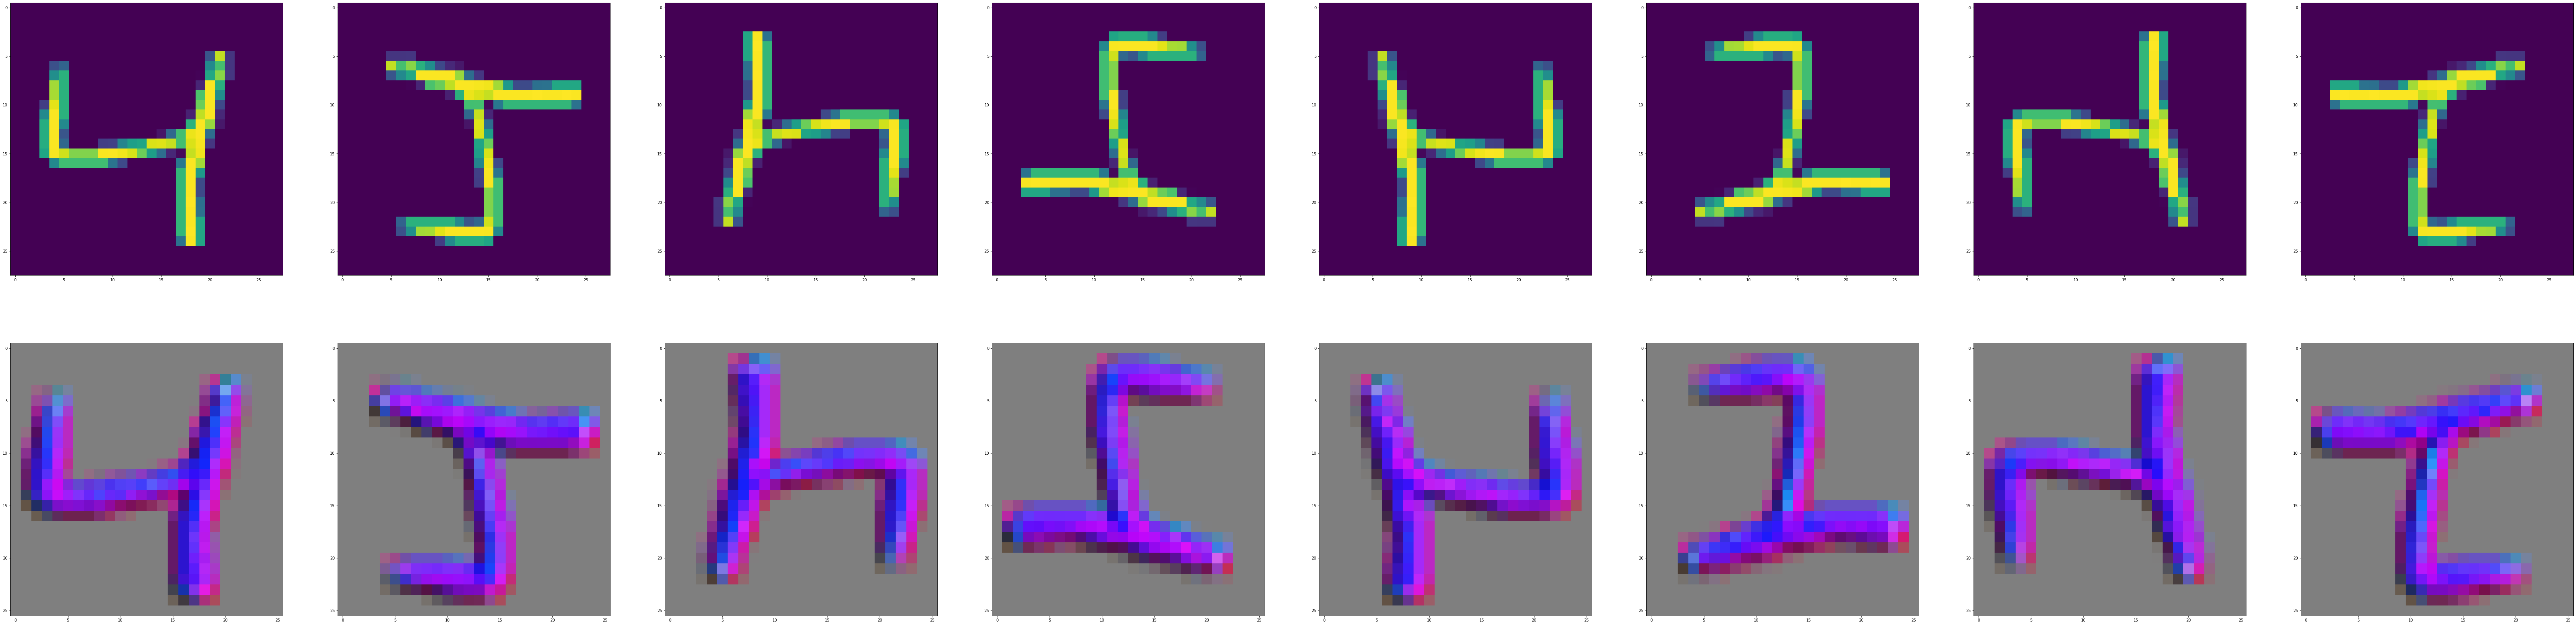

In [28]:
transformed_images = P4M_action(test_image[0], height_axis=0, width_axis=1)
lifted_images = lifting_conv(transformed_images)

fig, axes = plt.subplots(2, 8)
fig.set_figheight(2 * 15)
fig.set_figwidth(8 * 15)
gi = 3 # to visualize the output, just arbitrarily pick one group element 
for i in range(8):
  axes[0, i].imshow(np.reshape(transformed_images[i], transformed_images[i].shape[:-1]))
  axes[1, i].imshow(lifted_images[i][:, :, gi])

#### On a group convolution

Now we can use the previous layer to lift the image to a signal on the group, and test the equivariance of the group convolution layer on that.

In [29]:
lifted_image = lifting_conv(test_image)

group_conv(lifted_image)
group_conv.kernel = group_conv.kernel / tf.reduce_mean(tf.abs(group_conv.kernel))

for i in range(8):
  layer_g_input, g_layer_input, diff, maxdiff = test_equiv(lifted_image, group_conv, g_index=i, group_valued=True, verbose=False)
  print(f'{i}: {maxdiff}')

0: 0.0
1: 9.5367431640625e-07
2: 8.344650268554688e-07
3: 5.662441253662109e-07
4: 6.556510925292969e-07
5: 5.364418029785156e-07
6: 5.960464477539062e-07
7: 5.960464477539062e-07


Again this is practically equivariant!

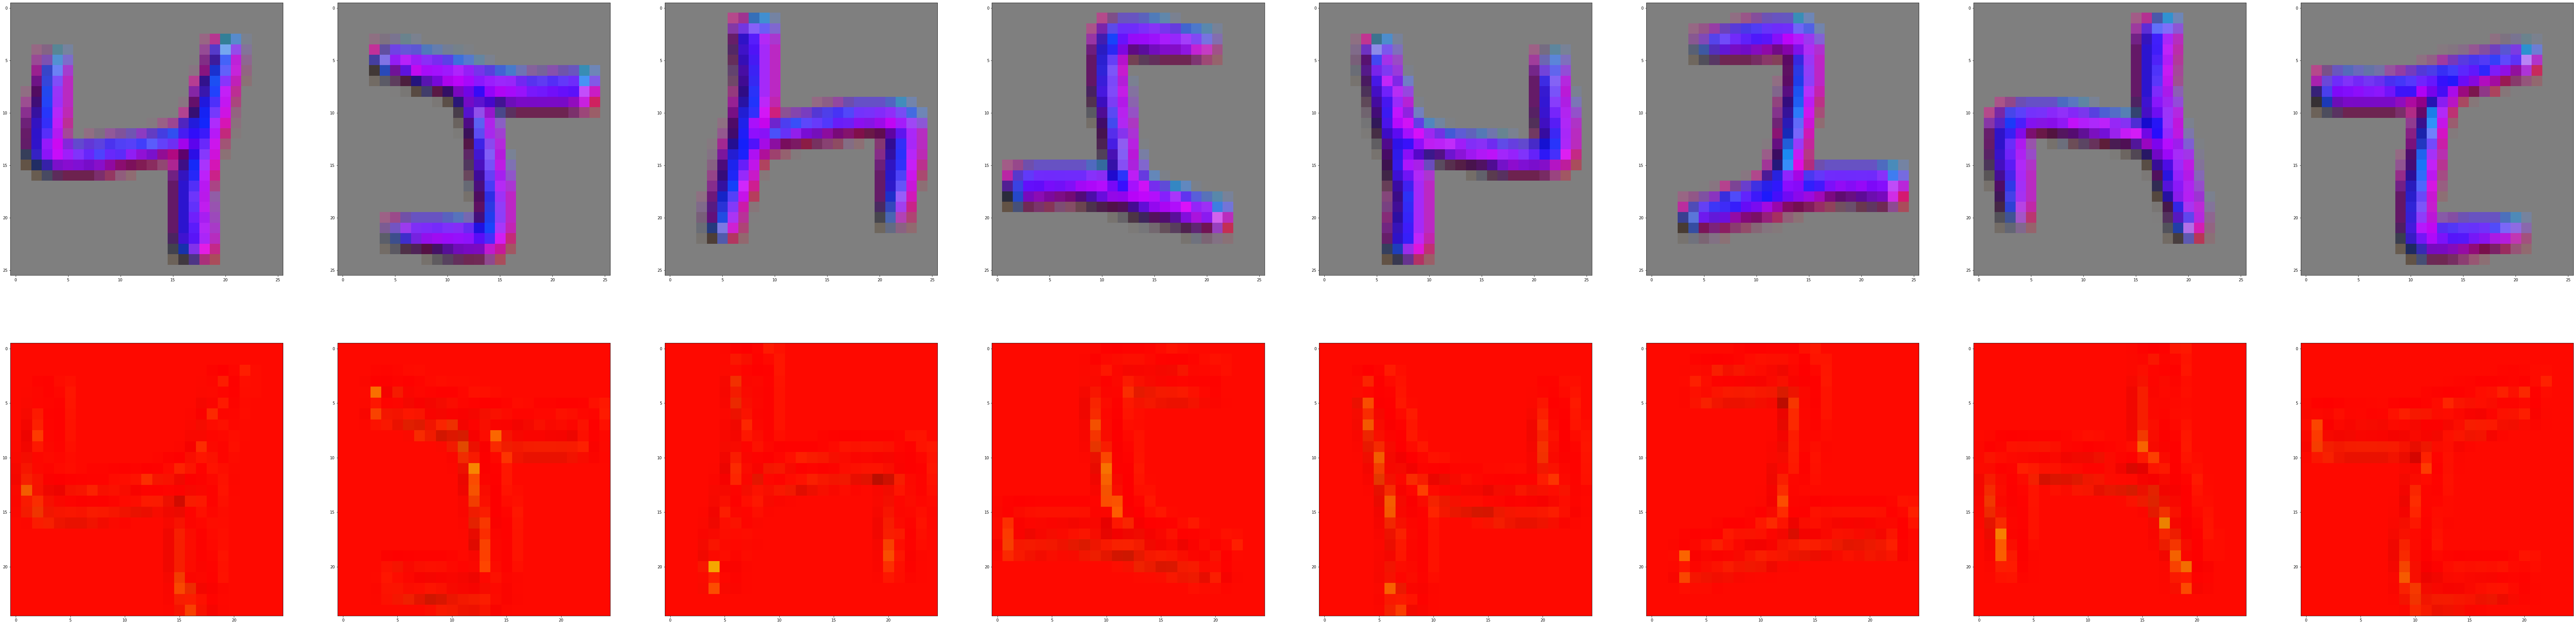

In [30]:
bla = group_conv(lifted_images)

fig, axes = plt.subplots(2, 8)
fig.set_figheight(2 * 15)
fig.set_figwidth(8 * 15)
gi = 3 # to visualize the output, just arbitrarily pick one group element 
for i in range(8):
  axes[0, i].imshow(lifted_images[i][:, :, gi])
  axes[1, i].imshow(bla[i][:, :, gi])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(5.9604645e-07, shape=(), dtype=float32)


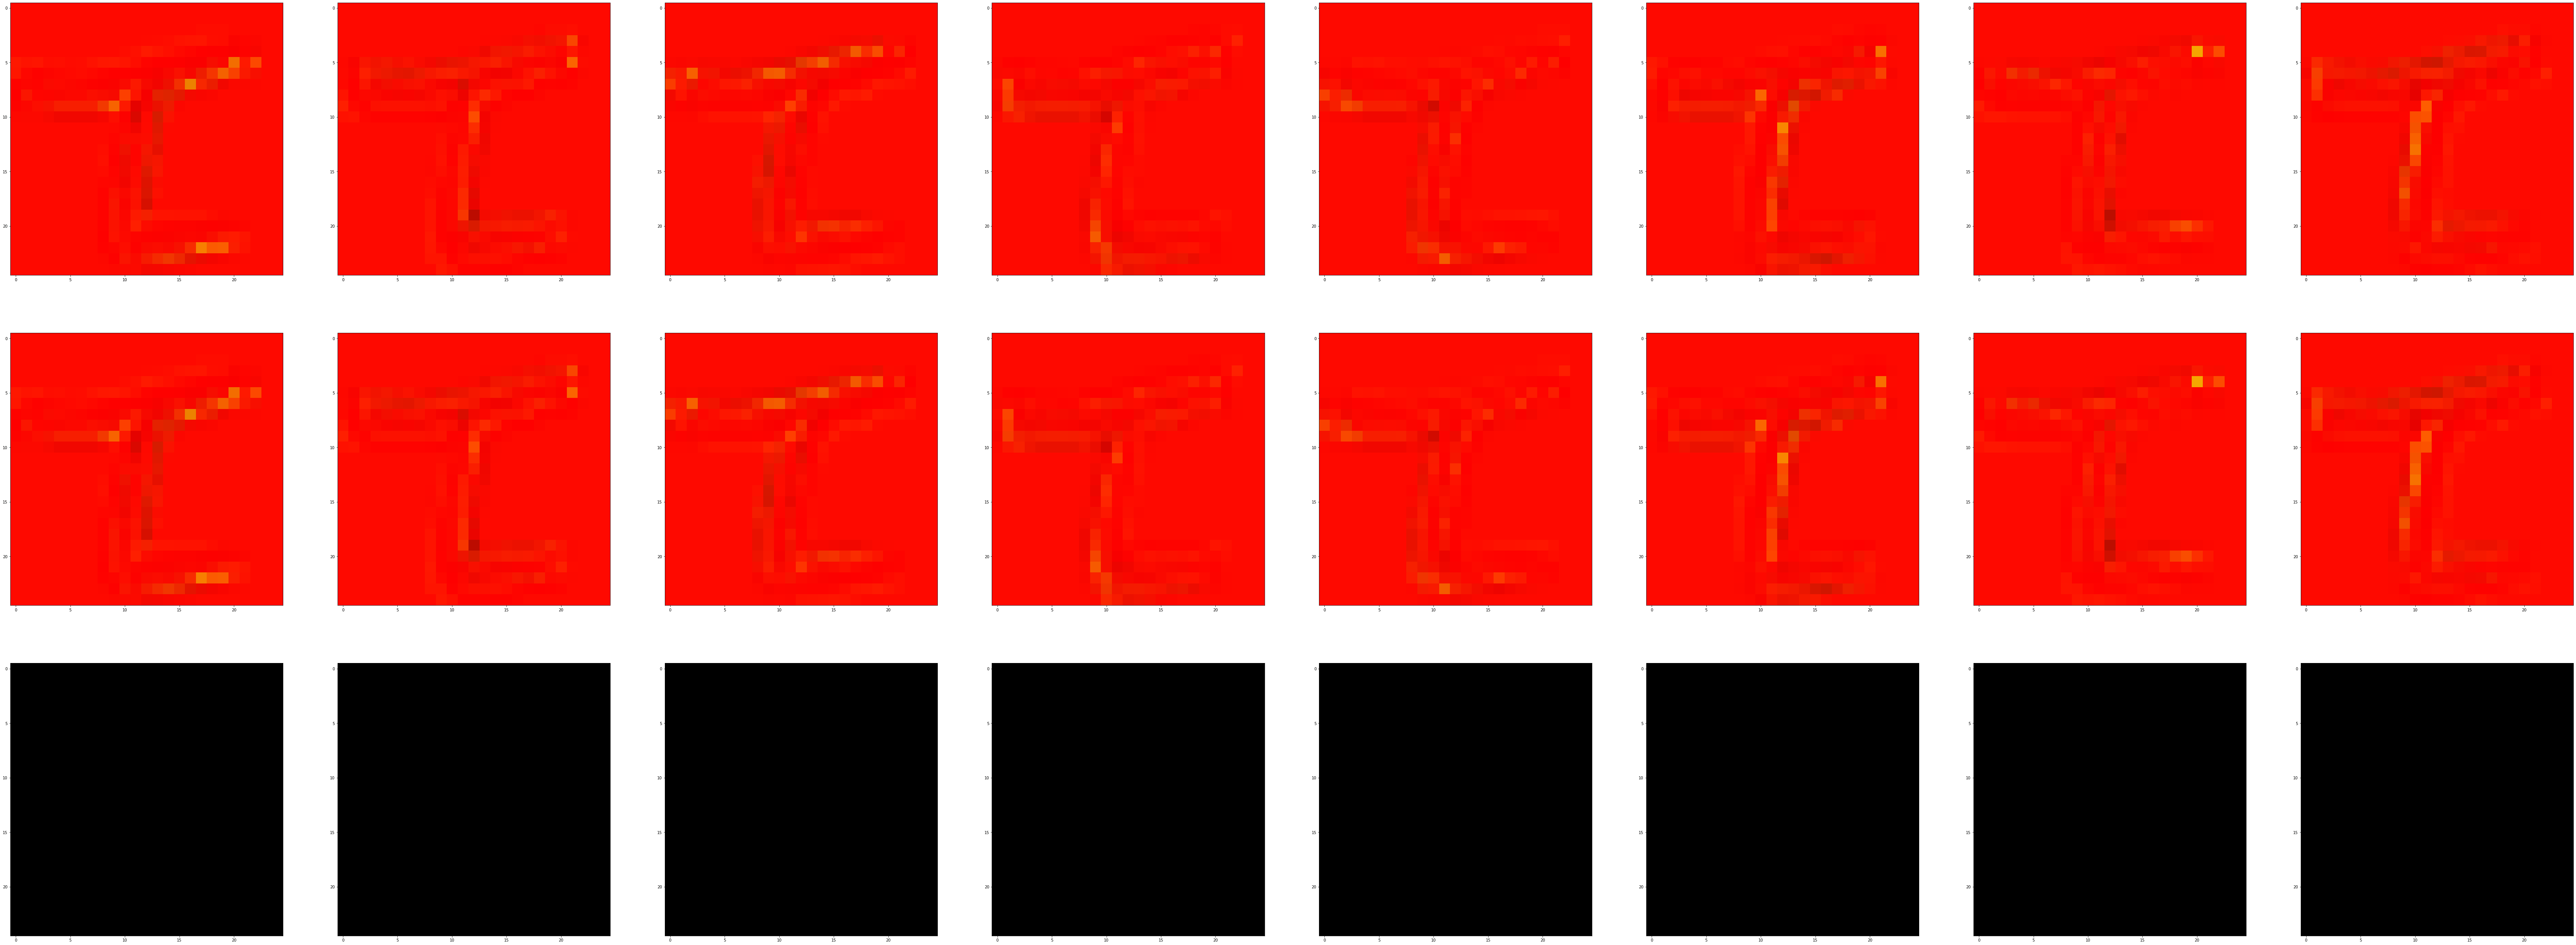

In [31]:
tsta = tf.transpose(layer_g_input, (0, 3, 1, 2, 4))[0]
tstb = tf.transpose(g_layer_input, (0, 3, 1, 2, 4))[0]

fig, axes = plt.subplots(3, 8)
fig.set_figheight(3 * 15)
fig.set_figwidth(8 * 15)
gi = 2 # to visualize the output, just arbitrarily pick one group element 
for i in range(8):
  axes[0, i].imshow(tsta[i])
  axes[1, i].imshow(tstb[i])
  axes[2, i].imshow((tsta - tstb)[i])
print(tf.reduce_max(tf.abs(tsta - tstb)))

## Equivariant layer: Pooling

Another equivariant layer is the pooling layer.

The simplest is to onl do spatial pooling, and leave the non-translational part intact.

It is also possible though to pool over the group, as long as what remains is a subgroup.

For now we will just do the simplest pooling. 
Note that this can be implemented very easily as a `MaxPooling3D` layer, using a `pool_size` of 1 in the first, group axis. 

Padding can spoil equivariance! It will lead to a relative shift

## Invariant layer: global pooling

The invariant layer is a global pooling layer, where now we pool over the full group, both the translational and the other part.

Again this can be implemented by just using the `GlobalPooling3D` layer.

# Testing on MNIST

We can now use these layers and test a full network on MNIST.

Below is a helper function that will allow us to construct a convolutional network, or a similar group-convolutional network.

In [32]:
from tensorflow import keras
import tensorflow as tf

In [65]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPooling3D, Dense, Dropout, Input, Flatten, GlobalMaxPooling2D, GlobalMaxPooling3D
from tensorflow.keras.models import Model

def create_pooling_layer(my_conv=Conv2D):
  if my_conv is Conv2D:
    return MaxPooling2D(pool_size=(2, 2))
  else:
    return MaxPooling3D(pool_size=(3, 3, 1), strides=(2, 2, 1), padding='valid')

def construct_model(my_conv=Conv2D, filter_sizes=[32, 64]):
  input_shape = (28, 28, 1)
  if my_conv is Conv2D:
    invariant = GlobalMaxPooling2D()
  else:
    invariant = GlobalMaxPooling3D() 
  inputs = Input(shape=input_shape)
  x = inputs
  for filters in filter_sizes[:-1]:
    x = my_conv(filters=filters, kernel_size=(3, 3), strides=1, activation='relu', padding='valid')(x)
    #x = create_pooling_layer(my_conv)(x)
  x = my_conv(filters=filter_sizes[-1], kernel_size=(3, 3), activation='relu', padding='valid')(x)
  x = invariant(x)
  #x = Dropout(0.5)(x)
  x = Dense(num_classes, activation='softmax')(x)
  outputs = x

  model = Model(inputs=inputs, outputs=outputs) 
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
  print(model.summary())
  return model

We can create both models with a similar amount of parameters and see which performs better.

## Regular CNN

In [66]:
regular_cnn = construct_model()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
global_max_pooling2d_6 (Glob (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                650       
Total params: 19,466
Trainable params: 19,466
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
batch_size = 128
epochs = 15
regular_cnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 4s 8ms/step - loss: 1.0410 - acc: 0.7149 - val_loss: 0.3769 - val_acc: 0.8967
Epoch 2/15
422/422 [==============================] - 3s 7ms/step - loss: 0.3618 - acc: 0.8915 - val_loss: 0.2737 - val_acc: 0.9167
Epoch 3/15
422/422 [==============================] - 3s 7ms/step - loss: 0.2879 - acc: 0.9093 - val_loss: 0.2384 - val_acc: 0.9255
Epoch 4/15
422/422 [==============================] - 3s 7ms/step - loss: 0.2442 - acc: 0.9242 - val_loss: 0.1991 - val_acc: 0.9377
Epoch 5/15
422/422 [==============================] - 3s 7ms/step - loss: 0.2216 - acc: 0.9307 - val_loss: 0.2047 - val_acc: 0.9360
Epoch 6/15
422/422 [==============================] - 3s 7ms/step - loss: 0.2007 - acc: 0.9371 - val_loss: 0.1663 - val_acc: 0.9505
Epoch 7/15
422/422 [==============================] - 3s 7ms/step - loss: 0.1880 - acc: 0.9404 - val_loss: 0.1721 - val_acc: 0.9460
Epoch 8/15
422/422 [==============================] - 3s 8ms/step - loss: 0.

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f07e9509f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


In [36]:
regular_cnn.evaluate(x_test, y_test, batch_size=batch_size)

79/79 [==============================] - 0s 4ms/step - loss: 0.1407 - acc: 0.9550


[0.14067965745925903, 0.9549999833106995]

## Group-CNN

In [67]:
group_cnn = construct_model(my_conv=P4M_Conv2D, filter_sizes=[32, 8])

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
group_conv2d_14 (GroupConv2D (None, 26, 26, 8, 32)     320       
_________________________________________________________________
group_conv2d_15 (GroupConv2D (None, 24, 24, 8, 8)      18440     
_________________________________________________________________
global_max_pooling3d_6 (Glob (None, 8)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                90        
Total params: 18,850
Trainable params: 18,850
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
batch_size = 128
epochs = 15
group_cnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
 25/422 [>.............................] - ETA: 8s - loss: 2.2976 - acc: 0.1488

KeyboardInterrupt: ignored

In [ ]:
group_cnn.evaluate(x_test, y_test, batch_size=batch_size)

The regular CNN performs much better. This is not very strange, we have imposed invariance to rotations and flips, but digits are not invariant to this. In particular the digits 6 and 9 even transform into one another under a 180 degree rotation.

If we randomly apply a transformation to each image, without changing the labels, we will artificially make the dataset invariant to this group. In this case we expect the group-CNN to perform better.

Before doing so, let's verify that it is invariant by looking at the maximal absolute difference of the class probabilities for transformed images:

In [59]:
# for i in range(1, 2):
#   regular_cnn.layers[i].kernel = regular_cnn.layers[i].kernel / tf.reduce_mean(tf.abs(regular_cnn.layers[i].kernel))
#   group_cnn.layers[i].kernel = group_cnn.layers[i].kernel / tf.reduce_mean(tf.abs(group_cnn.layers[i].kernel))

In [68]:
predictions = group_cnn(transformed_images) 
print("Predicted classes: ", tf.argmax(predictions, axis=1).numpy())
print("Maximal absolute difference in probabilities: ", tf.reduce_max(tf.abs(predictions - predictions[0])).numpy())
print("Mean absolute difference in probabilities: ", tf.reduce_mean(tf.abs(predictions - predictions[0])).numpy())

Predicted classes:  [2 2 2 2 2 2 2 2]
Maximal absolute difference in probabilities:  5.2154064e-08
Mean absolute difference in probabilities:  6.7055224e-09


Invariance isn't exact, probably mostly due to edge effects, but it's pretty good: a maximal difference in probabilities of just over one percent, and a mean well under one percent.

As a sanity check we can compare this to the regular CNN:

In [69]:
predictions = regular_cnn(transformed_images) 
print("Predicted classes: ", tf.argmax(predictions, axis=1).numpy())
print("Maximal absolute difference in probabilities: ", tf.reduce_max(tf.abs(predictions - predictions[0])).numpy())
print("Mean absolute difference in probabilities: ", tf.reduce_mean(tf.abs(predictions - predictions[0])).numpy())

Predicted classes:  [8 8 2 8 8 2 2 2]
Maximal absolute difference in probabilities:  0.0065681636
Mean absolute difference in probabilities:  0.0020325868


As expected the regular convolution is not invariant. 

When including any kind of downsampling though, either through a pooling layer or with strided convolutions, invariance is spoiled.